![](../BannerImage.png)

---

In this notebook, we'll go over the entire pipeline of creating a Binary Image Classifier using Tensorflow. We'll cover, all aspects of the pipeline such as experimenting with different network architectures and compairing metrics, pruning and quantization of the model for faster inference and finally two methods of deploying such models. We'll train a Convolutional Neural Network to recognize chest X-rays of people with pneumonia and then create a interactive web application.

![](../Toolkit.png)

# Packages 📦 and Basic Setup

In [1]:
%%capture

import os
import sys
import wandb
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')
from wandb.keras import WandbCallback
sys.path.append("X-Ray-Image-Classification/")
from deepxray.data import TFRecordsDataset

wandb_key = os.environ["WANDB_KEY"]
wandb.login(key = wandb_key);
wandb.init(project='xray-image-classification', entity='sauravmaheshkar')

# 💿 The Dataset

---

The Dataset for this project, titled "**Chest X-Ray Images (Pneumonia)**" was taken from Kaggle and was uploaded by [Paul Mooney](https://www.kaggle.com/paultimothymooney). More information about the dataset can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The dataset was organized into 3 folders ( *train, test, val* ) and contained subfolders for each image category (Pneumonia/Normal). There were 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

These images were then converted into TFRecords format, zipped and then upload as a [*Shared Dataset*](https://docs.deepnote.com/importing-and-exporing/importing-data-to-deepnote#uploading-files-to-deepnote) to the Deepnote Project. The script for converting these images into TFRecords can be found [here](https://github.com/SauravMaheshkar/X-Ray-Image-Classification/blob/main/scripts/create_tfrecord.py).

In the following cells, we extract the zip file and set some basic hyperparameters.



In [2]:
%%time

local_zip = '/datasets/chestxray/TFRecords.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/datasets/chestxray/')
zip_ref.close()

CPU times: user 1.12 s, sys: 345 ms, total: 1.46 s
Wall time: 12.7 s


## Config 📃

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = [512,512]
base_path = "/datasets/chestxray/TFRecords/"

TRAIN_FILENAMES = tf.io.gfile.glob(base_path + "/train/*.tfrecord")
VALID_FILENAMES = tf.io.gfile.glob(base_path + "/valid/*.tfrecord")
TEST_FILENAMES = tf.io.gfile.glob(base_path + "/test/*.tfrecord")

## 👁 Visualizing Few Examples

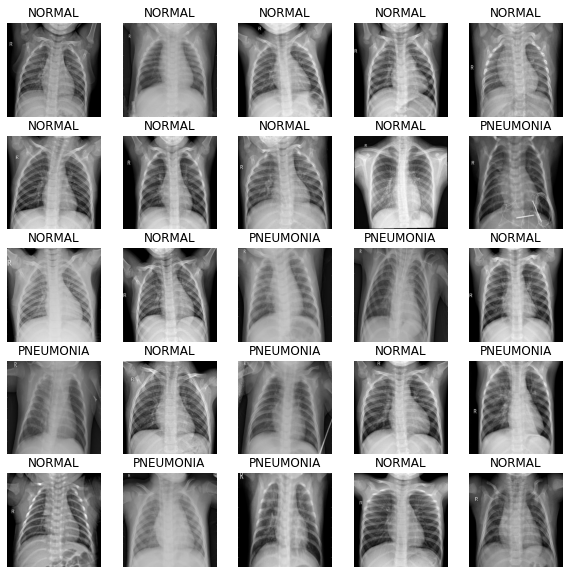

In [4]:
train_dataset = TFRecordsDataset(IMAGE_SIZE, BATCH_SIZE, TRAIN_FILENAMES).get_dataset(TRAIN_FILENAMES)
valid_dataset = TFRecordsDataset(IMAGE_SIZE, BATCH_SIZE, VALID_FILENAMES).get_dataset(VALID_FILENAMES)
test_dataset = TFRecordsDataset(IMAGE_SIZE, BATCH_SIZE, TEST_FILENAMES).get_dataset(TEST_FILENAMES)

image_batch, label_batch = next(iter(train_dataset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

# The Model 👷‍♀️

## 🏗 Transfer Learning

> Excerts from Datacamp Tutorials and MachineLearningMastery blogs

First things first; Transfer learning(TL) is not a machine learning model or technique; it is rather a "**design methodology**" within machine learning. The general idea of transfer learning is to use knowledge learned from tasks for which a lot of labelled data is available in settings where only little labelled data is available. Creating labelled data is expensive, so optimally leveraging existing datasets is key.

In a traditional machine learning model, the primary goal is to generalise to unseen data based on patterns learned from the training data. With transfer learning, you attempt to kickstart this generalisation process by starting from patterns that have been learned for a different task. Essentially, instead of starting the learning process from a (often randomly initialised) blank sheet, you start from patterns that have been learned to solve a different task.

Convolutional Neural Networks' features are more generic in early layers and more original-dataset-specific in later layers. Thus, we often use these as a backbone / starting point while creating new models. A common practice is to make these base models non-trainable and just learn the later layers. You might think that this will decrease the performance, but as we'll see from training. Transfer Learning is still a viable option.

## ⚖️ EfficientNetB0

<center> <img src="https://github.com/SauravMaheshkar/X-Ray-Image-Classification/blob/main/assets/effnet.png?raw=true"> </center>


> Excerpt from Google AI Blog

**Convolutional neural networks (CNNs)** are commonly developed at a fixed resource cost, and then scaled up in order to achieve better accuracy when more resources are made available. For example, ResNet can be scaled up from ResNet-18 to ResNet-200 by increasing the number of layers. The conventional practice for model scaling is to arbitrarily increase the CNN depth or width, or to use larger input image resolution for training and evaluation. While these methods do improve accuracy, they usually require tedious manual tuning, and still often yield suboptimal performance. Instead, the authors of [**"EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (ICML 2019)"**](https://arxiv.org/abs/1905.11946) found a more principled method to scale up a CNN to obtain better accuracy and efficiency. 


They proposed a novel model scaling method that uses a simple yet highly effective **compound coefficient** to scale up CNNs in a more structured manner. Unlike conventional approaches that arbitrarily scale network dimensions, such as width, depth and resolution, their method uniformly scales each dimension with a fixed set of scaling coefficients. The resulting models named **EfficientNets**, superpassed state-of-the-art accuracy with up to **10x** better efficiency (**smaller and faster**).

In this project we'll use **`EfficientNetB0`** for training our Binary Classifier. The Model can easily be instantiated using the **`tf.keras.applications`** Module, which provides canned architectures with pre-trained weights. For more details kindly visit [this](https://www.tensorflow.org/api_docs/python/tf/keras/applications) link.

In [5]:
def get_model():

    # Use EfficientNetB0 as the base
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )

    # Just fine-tune the layers
    base_model.trainable = False
    
    # Add a couple of layers
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    # Create a model with EfficientNetB0 as the base
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

# Training 💪🏻

## LearningRate Schedule and Callbacks

> From a [TowardsDataScience article](https://towardsdatascience.com/learning-rate-scheduler-d8a55747dd90)

In training deep networks, it is helpful to reduce the learning rate as the number of training epochs increases. This is *based on the intuition* that with a high learning rate, the deep learning model would possess high kinetic energy. As a result, it’s parameter vector bounces around chaotically. Thus, it’s unable to settle down into deeper and narrower parts of the loss function (local minima). If the learning rate, on the other hand, was very small, the system then would have low kinetic energy. Thus, it would settle down into shallow and narrower parts of the loss function (false minima).

<center> <img src = "https://miro.medium.com/max/668/1*iYWyu8hemMyaBlK6V-2vqg.png"> </center>

The above figure depicts that a high learning rate will lead to random to and fro moment of the vector around local minima while a slow learning rate results in getting stuck into false minima. Thus, knowing when to decay the learning rate can be hard to find out.

Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model. A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.

Here, we'll demonstrate how to use LearningRate schedules to automatically **adapt learning rates** that achieve the **optimal rate of convergence** for stochastic gradient descent. 

We'll also define some callbacks for :-

* **Checkpointing** ( A callback to save the model or weights at some frequency )
* **EarlyStopping** ( A callback to stop training when a monitored metric has stopped improving )
* **WandbCallback** ( Weights and Biases callback to automatically save all the metrics and the loss values tracked in `model.fit` )

In [6]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "pneumonia_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

* Some of you might be thinking why we use `SGD`, instead of `Adam` or `Nadam`. Well, using EfficientNet / Inception, we easily overfit the dataset after 2 epochs (validation accuracy = 1.000, loss = 0.002). Some recent papers also suggest that SGD learns way more robust models than Adam and as we are aiming for a production worthy model, robustness is a key factor to consider.

In [7]:
# All you need to run on GPU !!
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = get_model()
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
        loss="binary_crossentropy",
        metrics=tf.keras.metrics.AUC(name="auc"),
    )

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
    verbose = 1
)

# Save it as model artifact on W&B
model.save('model.h5')

artifact =  wandb.Artifact(name="model", type="weights")
artifact.add_file("model.h5")
wandb.log_artifact(artifact)

16711680/16705208 [==============================] - 0s 0us/step
Epoch 1/5
82/82 [==============================] - 118s 1s/step - loss: 0.6006 - auc: 0.7018 - val_loss: 1.1099 - val_auc: 0.7578
Epoch 2/5
82/82 [==============================] - 98s 1s/step - loss: 0.4455 - auc: 0.8686 - val_loss: 1.2539 - val_auc: 0.8125
Epoch 3/5
82/82 [==============================] - 98s 1s/step - loss: 0.3918 - auc: 0.9016 - val_loss: 1.3470 - val_auc: 0.8047
Epoch 4/5
82/82 [==============================] - 98s 1s/step - loss: 0.3956 - auc: 0.8945 - val_loss: 1.2601 - val_auc: 0.8203
Epoch 5/5
82/82 [==============================] - 98s 1s/step - loss: 0.3525 - auc: 0.9074 - val_loss: 1.3567 - val_auc: 0.8047


# 🧐 Metrics (Weights and Biases Experiment Tracking)

<center> <img src="https://raw.githubusercontent.com/SauravMaheshkar/X-Ray-Image-Classification/1a2621651e247210562418cbecaa5ea6510f7acf/assets/Validation%20AUC.svg"> </center>

<center> <img src="https://raw.githubusercontent.com/SauravMaheshkar/X-Ray-Image-Classification/1a2621651e247210562418cbecaa5ea6510f7acf/assets/Validation%20Loss.svg"> </center>

It takes a lot of time to train models, that's we use Weights and Biases Artifacts to store our models. You can store different versions of your datasets and models in the cloud as Artifacts. Think of an Artifact as of a folder of data to which we can add individual files, and then upload to the cloud as a part of our W&B project, which also supports automatic versioning of datasets and models. Artifacts also track the training pipelines as DAGs. Here's an example of a artifacts graph.

<center> <img src="https://i.imgur.com/QQULnpP.gif"> </center>

# ✂️ Quantisation

> Excerpts from [my work](https://wandb.ai/sauravmaheshkar/exploring-bias-and-compression/reports/What-Do-Compressed-Deep-Neural-Networks-Forget---Vmlldzo1NzA0NDY) and [qualcomm blogpost](https://www.qualcomm.com/news/onq/2019/03/12/heres-why-quantization-matters-ai)

<center> <img src=https://www.qualcomm.com/sites/ember/files/blog/managed-images/qc-tech_quantization_gif-2_final.gif> </center>

Current state-of-the-art models are famously **huge** and **over-parameterized**––in fact, they contain way more parameters than the number of data points in the dataset. These models require **enormous amounts of computation and memory** and that not only increases the infrastructure costs, but also makes deployment to resource-constrained environments such as mobile phones or smart devices challenging. 

With this push towards bigger and deeper models comes the competing need for fast deployment and efficiency. One tactic that solves some of this give-and-take is **compression**. One way to reduce the AI computation demands and increase power efficiency is through **quantization**. Quantization is an umbrella term that covers a lot of different techniques to convert input values from a large set to output values in a smaller set. Quantization, in essence, **lessens the number of bits needed to represent information**. Lower-precision mathematical operations, such as an 8-bit integer multiply versus a 32-bit floating point multiply, **consume less energy** and **increase compute efficiency**, thus **reducing power consumption**. In addition, reducing the number of bits for representing the neural network’s parameters results in **less memory storage**. What’s the catch of using low-bit networks? Typically, the accuracy of the quantized AI model tends to drop.

---

Here, we quantise the model using the [TFLiteConverter](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter?hl=en), with the [default](https://www.tensorflow.org/api_docs/python/tf/lite/Optimize?hl=en) optimization strategy and then convert the model into **`.tflite`** file. Next up we'll use this quantized model to run inference in our web application.

In [8]:
model.load_weights('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

file = open('quantized_model.tflite', 'wb') 
file.write(quantized_model)

# Save it as model artifact on W&B
quantized_artifact =  wandb.Artifact(name="quantized_model", type="weights")
quantized_artifact.add_file("quantized_model.tflite")
wandb.log_artifact(quantized_artifact)

# 🚀 Deployment


As deep learning is infiltrating most industries, learning how to deploy models into production is becoming an extremely important skill to master. In this notebook, we'll go over two methods to deploy our trained model.

1. Web Application built using [Streamlit](https://streamlit.io/) (Uses Quantized TFLite model)
2. Using [Tensorflow Serving](https://www.tensorflow.org/tfx/guide/serving) (Uses SavedModel Format)

## Streamlit Web Application

<center> <img src = "https://github.com/SauravMaheshkar/X-Ray-Image-Classification/blob/main/assets/xray-app.gif?raw=true"> </center>

**[Link to the web app](https://share.streamlit.io/sauravmaheshkar/x-ray-image-classification/streamlit/demo/app.py)**

Streamlit is probably the fastest way to share data models. Rather than Flask or Django which requires the developer to know a little bit about HTML, CSS and JavaScript, using Streamlit you can build responsive applications using just python. It has an extremely simple API and has a [free sharing platform](https://share.streamlit.io/), where you can deploy your local model to a website in just a few clicks. 

The code for this app can be found in the accompanying [Github Repository](https://github.com/SauravMaheshkar/X-Ray-Image-Classification). I have also shared a [Docker Image](https://github.com/SauravMaheshkar/X-Ray-Image-Classification/packages/745856) for you to be able to clone and run the model locally using just 2 commands.

## Tensorflow Serving

TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data.

I have upload a [custom serving image](https://github.com/SauravMaheshkar/X-Ray-Image-Classification/packages/746338) (with the model mounted) built on top of the tensorflow/serving image. You can clone this image expose a port and call it using a REST API.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=33b203d4-0067-4eac-ac51-ded44ae21a53' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>